# Computational Cosmology
---
This project has been developed for the course Cosmology within the Master’s Degree in Physics at the University of Valencia. Its objective is to demonstrate the use of standard scientific libraries together with specialized astrophysical libraries in computational cosmology. The project applies numerical and data analysis techniques commonly used in modern cosmological research. It illustrates how these tools can be integrated to model cosmological scenarios and analyze data.

### Authors
- Alejandro Estellés Roig (aesroig@alumni.uv.es)
- Juan Ramón Díaz Santos (diazjuan@alumni.uv.es)

# Cosmological Standar Model
---
This notebook implements a numerical integration of the Friedmann equations in order to study the dynamical evolution of the scale factor in standard cosmological models. The integration is performed using well-established scientific computing libraries to ensure accuracy and stability. From the resulting solutions, isochrone curves are constructed to represent the cosmic time evolution in different cosmological scenarios.

1. Integration of Friedmann Equation
2. Isochrones in the cosmological parameter plane

## 0. Libraries and System Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad



## 1. Integration of Friedmann Equation
---
In homogeneous and isotropic cosmology, the dynamics of the universe is described by the Friedmann–Lemaître–Robertson–Walker (FLRW) metric, whose evolution is governed by the Friedmann equations derived from Einstein’s field equations. For a universe filled with pressureless matter (dust), curvature, and a cosmological constant, the first Friedmann equation reads

$$
\left(\frac{\dot a}{a}\right)^2 = H_0^2 \left( \frac{\Omega_4}{a^4} +  \frac{\Omega_m}{a^3} + \frac{\Omega_k}{a^2} + \Omega_\Lambda \right),
$$

where $a(t)$ is the scale factor, $H_0$ is the present Hubble constant, and $\Omega_m$, $\Omega_k$, and $\Omega_\Lambda$ are the density parameters associated with matter, spatial curvature, and dark energy, respectively.

Introducing the dimensionless time variable $\tau = H_0 t$, the evolution equation can be written in normalized form as

$$
\frac{da}{d\tau} = a \sqrt{ \frac{\Omega_r}{a^4} + \frac{\Omega_m}{a^3} + \frac{\Omega_k}{a^2} + \Omega_\Lambda}.
$$

This section implements a numerical integration of this equation for different cosmological models by specifying distinct sets of density parameters $(\Omega_m, \Omega_\Lambda, \Omega_k, \Omega_r)$. The goal is to illustrate how the choice of cosmological parameters affects the expansion history of the universe, and to provide a simple computational example of the Friedmann dynamics in dimensionless form.


In [2]:
# ------------------------------------------------------------
# Normalized Friedmann equation for a dust + curvature + Lambda universe
#
# We evolve the scale factor a(τ) using a dimensionless time:
#     τ = H0 * t
#
# With density parameters:
#     Ωm : matter (dust)
#     ΩΛ : cosmological constant
#     Ωk : curvature
#
# The normalized Friedmann constraint is:
# (1/a da/dτ)^2 = Ωr/a^4 + Ωm/a^3 + Ωk/a^2 + ΩΛ
#
# Therefore:
#     da/dτ = a * sqrt( Ωr/a^4 + Ωm/a^3 + Ωk/a^2 + ΩΛ )
#
# When sign of argumen is negative (Closed Universe after turnaround point)
#     da/dτ = sgn * a * sqrt(...)
# -------------------------------
def rhs_friedmann(tau, y, Om, OL, Ok, Or, sgn):
    """
    Right-hand side of the ODE da/dτ = a * sqrt(Ωm/a^3 + Ωk/a^2 + ΩΛ).

    Parameters
    ----------
    tau : float
        Dimensionless time τ = H0 t (independent variable).
    a : array_like
        Scale factor a(τ). solve_ivp passes state variables as an array.
    Omega_r : float
        Radiation density parameter Ωr.
    Omega_m : float
        Matter density parameter Ωm.
    Omega_L : float
        Cosmological constant density parameter ΩΛ.
    Omega_k : float
        Curvature density parameter Ωk.

    Returns
    -------
    da_dtau : float
        Derivative da/dτ.
    """
    a = y[0]
    arg = Or/a**4 + Om/a**3 + Ok/a**2 + OL
    if arg <= 0:
        # Argument never can be negative
        return [0.0]
    return [sgn * a * np.sqrt(arg)]

def arg_H2(tau, y, Om, OL, Ok, Or):
    a = y[0]
    return Or/a**4 + Om/a**3 + Ok/a**2 + OL

# Event: turnaround when H^2 -> 0 (arg -> 0)
def event_turnaround(tau, y, Om, OL, Ok, Or):
    return arg_H2(tau, y, Om, OL, Ok, Or)

In [3]:
# When H^2 > 0 Stop integration and change direction 
event_turnaround.terminal = True
event_turnaround.direction = -1

def integrate_model(tau_span, tau_eval, a_ini, Om, OL, Ok, Or,
                    rtol=1e-9, atol=1e-12, max_step=0.02,
                    eps_restart=1e-9):
    # Expanding branch
    sol1 = solve_ivp(
        fun=lambda t, y: rhs_friedmann(t, y, Om, OL, Ok, Or, sgn=+1),
        t_span=tau_span,
        y0=[a_ini],
        t_eval=tau_eval,
        rtol=rtol, atol=atol, max_step=max_step,
        events=lambda t, y: event_turnaround(t, y, Om, OL, Ok, Or)
    )

    # If no turnaround, done
    if sol1.t_events[0].size == 0:
        return sol1.t, sol1.y[0], None

    # Turnaround point
    tau_turn = sol1.t_events[0][0]
    a_turn   = sol1.y_events[0][0][0]

    # Restart slightly below a_turn so arg>0 and contraction can proceed
    a_start   = a_turn * (1.0 - eps_restart)
    tau_start = tau_turn + 1e-12  # tiny shift to avoid event re-triggering

    # Contracting branch only for times after turnaround
    tau_eval2 = tau_eval[tau_eval >= tau_start]

    sol2 = solve_ivp(
        fun=lambda t, y: rhs_friedmann(t, y, Om, OL, Ok, Or, sgn=-1),
        t_span=(tau_start, tau_span[1]),
        y0=[a_start],
        t_eval=tau_eval2,
        rtol=rtol, atol=atol, max_step=max_step
    )

    # Merge solutions
    t = np.concatenate([sol1.t, sol2.t])
    a = np.concatenate([sol1.y[0], sol2.y[0]])

    return t, a, (tau_turn, a_turn)


In [4]:
# -------------------------------
# ------------------------------------------------------------
# Initial condition: very small universe
# ------------------------------------------------------------
a_ini = 1e-3

# Integration range in dimensionless time units τ = H0 t
tau_span = (0, 5)

# Times at which we store the solution
tau_eval = np.linspace(tau_span[0], tau_span[1], 2200)

# realistic present radiation fraction (order of magnitude)
Omega_r0 = 9e-5 

# ------------------------------------------------------------
# Cosmological cases: (Ωm, ΩΛ, Ωk, Ωr)
# Note: - In standard cosmology, Ωk = 1 - Ωm - ΩΛ.
#       - Here we specify Ωk explicitly for each scenario.
# ------------------------------------------------------------
cosmos = {
    r"Flat dust ($\Omega_m=1$)"                          : (1.0, 0.0, 0.0, 0.0),
    r"$\Lambda$CDM ($\Omega_m=0.3,\Omega_\Lambda=0.7$)"  : (0.3, 0.7, 0.0, Omega_r0),
    r"Open ($\Omega_m=0.3,\Omega_\Lambda=0$)"            : (0.3, 0.0, 0.7, 0.0),
    r"Closed ($\Omega_m=1.3,\Omega_\Lambda=0$)"          : (1.3, 0.0,-0.7, 0.0),
    r"de Sitter ($\Omega_\Lambda=1$)"                    : (0.0, 1.0, 0.0, 0.0),
    r"Milne ($\Omega_k=1$)"                              : (0.0, 0.0, 1.0, 0.0),
    r"Radiation dom. ($\Omega_r=1$)"                     : (0.0, 0.0, 0.0, 1.0),
}

# Integrate
solutions = {}
turnarounds = {}
for label, (Om, OL, Ok, Or) in cosmos.items():
    t, a, ta = integrate_model(tau_span, tau_eval, a_ini, Om, OL, Ok, Or)
    solutions[label] = (t, a)
    if ta is not None:
        turnarounds[label] = ta  # (tau_turn, a_turn)

# Define "today" as τ0 where ΛCDM reaches a=1
lcdm_label = r"$\Lambda$CDM ($\Omega_m=0.3,\Omega_\Lambda=0.7$)"
t_lcdm, a_lcdm = solutions[lcdm_label]
tau0 = np.interp(1.0, a_lcdm, t_lcdm) if (a_lcdm.min() <= 1.0 <= a_lcdm.max()) else None

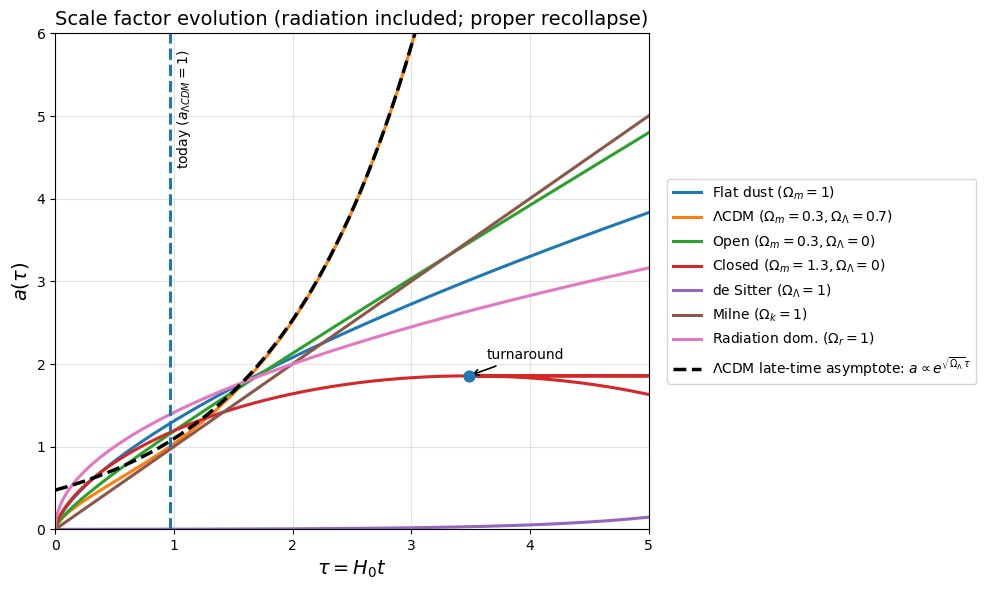

In [5]:
# -------------------------------
# plot
# -------------------------------
plt.figure(figsize=(10, 6))

# Plot main curves
for label, (t, a) in solutions.items():
    plt.plot(t, a, linewidth=2.2, label=label)

# Mark turnaround for closed models
for label, (tt, at) in turnarounds.items():
    plt.scatter([tt], [at], s=60, zorder=5)
    plt.annotate("turnaround", (tt, at), xytext=(tt+0.15, at+0.2),
                 arrowprops=dict(arrowstyle="->", lw=1.2))

# Vertical line for today
if tau0 is not None:
    plt.axvline(tau0, linestyle="--", linewidth=2.2)
    plt.text(tau0+0.05, 5.8, r"today ($a_{\Lambda CDM}=1$)", rotation=90, va="top")

# ΛCDM de Sitter asymptote (matched at late time)
Om, OL, Ok, Or = cosmos[lcdm_label]
if OL > 0:
    tau_star = t_lcdm[-1]
    a_star = a_lcdm[-1]
    A = a_star * np.exp(-np.sqrt(OL)*tau_star)
    a_asym = A * np.exp(np.sqrt(OL)*tau_eval)
    plt.plot(tau_eval, a_asym, "k--", lw=2.5,
             label=r"$\Lambda$CDM late-time asymptote: $a\propto e^{\sqrt{\Omega_\Lambda}\tau}$")

plt.xlabel(r"$\tau = H_0 t$", fontsize=14)
plt.ylabel(r"$a(\tau)$", fontsize=14)
plt.title("Scale factor evolution (radiation included; proper recollapse)", fontsize=14)

plt.grid(True, alpha=0.35)
plt.xlim(*tau_span)
plt.ylim(0, 6)

# Put legend outside to avoid covering curves
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.tight_layout()
plt.show()



## 2. Isochrones in the cosmological parameter plane

In a homogeneous and isotropic universe described by the FLRW metric, the expansion rate is governed by the Friedmann equation

$$
H^2(a) = H_0^2 \left( \frac{\Omega_m}{a^3} + \frac{\Omega_k}{a^2} + \Omega_\Lambda \right),
$$

where $a$ is the scale factor and $\Omega_m, \,\Omega_k, \text{ and } \Omega_\Lambda$ are the present-day density parameters of matter, curvature, and the cosmological constant, respectively.

The age of the universe $t_0$ is obtained by integrating the inverse Hubble rate:

$
H_0 t_0 = \int_0^1 \frac{da}{a \sqrt{\Omega_m/a^3 + \Omega_k/a^2 + \Omega_\Lambda}}.
$

This notebook evaluates this integral numerically over a grid in the $\Omega_m, \Omega_\Lambda)$ plane and plots contours of constant dimensionless age $H_0 t_0$ (isochrones). Additional reference curves are shown: the flat-universe line $\Omega_k=0$, the transition between decelerated and accelerated expansion $q_0=0$, and the boundary between eternal expansion and recollapse. These diagrams provide a geometric visualization of how cosmological parameters determine the age and fate of the universe.


In [7]:
# -------------------------
# Age of the universe (dimensionless H0 t0)
# -------------------------
def age_of_universe(Om, OL):
    """
    Computes the dimensionless age of the universe H0 t0
    for given values of Ωm and ΩΛ, assuming Ωk = 1 - Ωm - ΩΛ.

    The age is given by:
        H0 t0 = ∫_{0}^{1} da / (a * sqrt(Ωm/a^3 + Ωk/a^2 + ΩΛ))

    Parameters
    ----------
    Om : float
        Matter density parameter Ωm.
    OL : float
        Cosmological constant density parameter ΩΛ.

    Returns
    -------
    float
        Dimensionless age H0 t0, or NaN if the model is not physical.
    """
    Ok = 1.0 - Om - OL  # curvature parameter

    # Integrand of the age integral
    def integrand(a):
        E2 = Om/a**3 + Ok/a**2 + OL  # E(a)^2 = H(a)^2 / H0^2
        # If H^2 becomes negative, the model is not physical
        if E2 <= 0:
            return np.nan
        return 1.0 / (a * np.sqrt(E2))

    try:
        # Integrate from very small scale factor to today (a=1)
        val, _ = quad(integrand, 1e-6, 1.0, limit=200)
        return val
    except:
        return np.nan


In [8]:
# -------------------------
# Grid in the (Ωm, ΩΛ) plane
# -------------------------
Om_vals = np.linspace(0.0, 3.0, 150)
OL_vals = np.linspace(-1.5, 3.0, 150)
Om_grid, OL_grid = np.meshgrid(Om_vals, OL_vals)

# Array to store H0 t0 values
Ht_grid = np.zeros_like(Om_grid)

# Compute the age for each point in parameter space
for i in range(Om_grid.shape[0]):
    for j in range(Om_grid.shape[1]):
        Ht_grid[i, j] = age_of_universe(Om_grid[i, j], OL_grid[i, j])



C:\Users\Juan\AppData\Local\Temp\ipykernel_19472\4240962845.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(integrand, 1e-6, 1.0, limit=200)


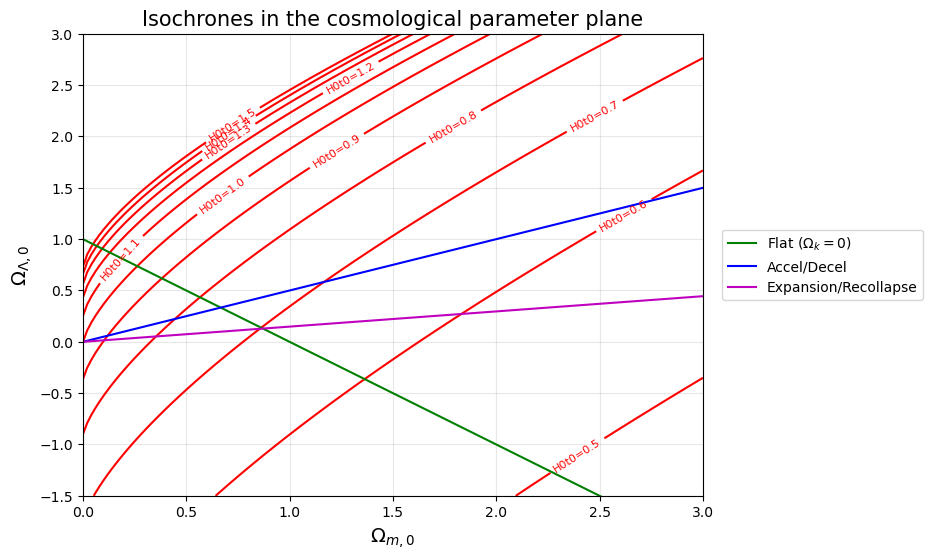

In [9]:
# -------------------------
# Plot: Isochrones in the cosmological parameter plane
# -------------------------
plt.figure(figsize=(8,6))

# Contours of constant age H0 t0
cs = plt.contour(
    Om_grid, OL_grid, Ht_grid,
    levels=np.arange(0.5, 1.6, 0.1),
    colors='red'
)
plt.clabel(cs, inline=True, fontsize=8, fmt="H0t0=%.1f")

# Boundary lines
Om = np.linspace(0, 3, 200)

# Curvature line: flat universe (Ωk = 0)
plt.plot(Om, 1 - Om, 'g-', label=r"Flat ($\Omega_k=0$)")

# Acceleration/deceleration transition:
# q0 = 0  ->  ΩΛ = Ωm / 2
plt.plot(Om, Om/2, 'b-', label="Accel/Decel")

# Recollapse boundary (for Λ = 0 dust model):
# ΩΛ = (4/27) Ωm
plt.plot(Om, 4*Om/27, 'm-', label="Expansion/Recollapse")

plt.xlabel(r"$\Omega_{m,0}$", fontsize=14)
plt.ylabel(r"$\Omega_{\Lambda,0}$", fontsize=14)
plt.title("Isochrones in the cosmological parameter plane", fontsize=15)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
plt.ylim(-1.5, 3.0)
plt.xlim(0, 3.0)
plt.grid(alpha=0.3)
plt.show()
